## Project

This project explores whether we can **reasonably predict a developer’s annual compensation**
using self-reported survey data from the 2025 Stack Overflow Developer Survey.

#### Project motivations:
- I would like to understand how coding experience, programming language, years of coding experience, education level, and job positions affect the salary of developers.
- I also wonder if it is possible to predict the salary using these factors.

## Section 1: Business Understanding
#### The project aim to answer below questions.
- How does the coding experience influence salary of developer?
- How does the role affect the salary of developers?
- Does developer salary vary with country?
- Would education level change the salary of developers?
- Which language has highest salary?
- Can we train a Random Forest Model to predict salary using selected features?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import os
import joblib

pd.set_option("display.max_columns", 50)

## Section 2: Data Understanding

#### Gather dataset

- Source: 2025 Stack Overflow Developer Survey (ODbL license)
- Respondents: 49,000+ responses from 177 countries
- Data type: Self-reported survey responses

In [2]:
DATA_PATH = "../data/raw/survey_results_public.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)

(49191, 172)


C:\Users\witch\AppData\Local\Temp\ipykernel_18080\2350051872.py:3: DtypeWarning: Columns (56,74,92,97,98,105,109,110,132,162,165) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


In [3]:
df.head()

,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,AILearnHow,YearsCode,DevType,OrgSize,ICorPM,RemoteWork,PurchaseInfluence,TechEndorseIntro,TechEndorse_1,TechEndorse_2,TechEndorse_3,TechEndorse_4,TechEndorse_5,TechEndorse_6,TechEndorse_7,...,AIAgentChange,AIAgent_Uses,AgentUsesGeneral,AIAgentImpactSomewhat agree,AIAgentImpactNeutral,AIAgentImpactSomewhat disagree,AIAgentImpactStrongly agree,AIAgentImpactStrongly disagree,AIAgentChallengesNeutral,AIAgentChallengesSomewhat disagree,AIAgentChallengesStrongly agree,AIAgentChallengesSomewhat agree,AIAgentChallengesStrongly disagree,AIAgentKnowledge,AIAgentKnowWrite,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,14.0,"Developer, mobile",20 to 99 employees,People manager,Remote,"Yes, I influenced the purchase of a substantia...",Work,10.0,7.0,9.0,6.0,3.0,11.0,12.0,...,Not at all or minimally,Software engineering,NaN,AI agents have increased my productivity.;AI a...,AI agents have helped me automate repetitive t...,NaN,NaN,NaN,I am concerned about the accuracy of the infor...,Integrating AI agents with my existing tools a...,The cost of using certain AI agent platforms i...,NaN,NaN,NaN,NaN,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,10.0,"Developer, back-end",500 to 999 employees,Individual contributor,"Hybrid (some in-person, leans heavy to flexibi...",No,Personal Project,13.0,1.0,2.0,9.0,4.0,3.0,12.0,...,Not at all or minimally,NaN,NaN,NaN,NaN,NaN,NaN,NaN,It takes significant time and effort to learn ...,NaN,I am concerned about the accuracy of the infor...,Integrating AI agents with my existing tools a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps;Technical ...,12.0,"Developer, front-end",NaN,NaN,NaN,No,Work,12.0,2.0,3.0,7.0,5.0,10.0,13.0,...,"Yes, somewhat",Software engineering,Multi-platform search enablement,AI agents have increased my productivity.;AI a...,AI agents have improved the quality of my code...,AI agents have improved collaboration within m...,NaN,NaN,It takes significant time and effort to learn ...,My company's IT and/or InfoSec teams have stri...,NaN,I am concerned about the accuracy of the infor...,NaN,Redis,NaN,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0
3,4,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,None of the above,4.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps;Videos (no...,5.0,"Developer, back-end","10,000 or mor

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49191 entries, 0 to 49190
Columns: 172 entries, ResponseId to JobSat
dtypes: float64(52), int64(1), object(119)
memory usage: 64.6+ MB


## Section 3: Data Preparation

#### Step 1. Select the relevant features and target to clean the dataframe

- Years of professional coding experience
- Country
- Primary developer role
- Primary programming language
- Education level
- Annual compensation (USD, normalized by Stack Overflow)

In [5]:
columns = [
    "ConvertedCompYearly",
    "YearsCode",
    "Country",
    "DevType",
    "LanguageHaveWorkedWith",
    "EdLevel"
]

df = df[columns]
df.head()

,ConvertedCompYearly,YearsCode,Country,DevType,LanguageHaveWorkedWith,EdLevel
0,61256.0,14.0,Ukraine,"Developer, mobile",Bash/Shell (all shells);Dart;SQL,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)"
1,104413.0,10.0,Netherlands,"Developer, back-end",Java,"Associate degree (A.A., A.S., etc.)"
2,53061.0,12.0,Ukraine,"Developer, front-end",Dart;HTML/CSS;JavaScript;TypeScript,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)"
3,36197.0,5.0,Ukraine,"Developer, back-end",Java;Kotlin;SQL,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)"
4,60000.0,22.0,Ukraine,Engineering manager,C;C#;C++;Delphi;HTML/CSS;Java;JavaScript;Lua;P...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)"


#### Step 2. Remove the invalid data and outliers
- All the none data is removed.
- The extremely low (<5000) and high (>500,000) salary data are considered as outliers and removed.

In [6]:
df = df.rename(columns={"ConvertedCompYearly": "salary"})

# Filter out the invalid data (none, <5000 or >500,000)
df = df[
    (df["salary"].notna()) &
    (df["salary"] > 5000) &
    (df["salary"] < 500_000)
]

print(df.shape)

(22015, 6)


#### Step 3. Convert data type and clean the data
- Coding experience is numerical data with unit of Years. Non-numeric data is removed.

In [7]:
df["YearsCode"] = pd.to_numeric(
    df["YearsCode"], errors="coerce"
)

df = df[df["YearsCode"].notna()]

print(df.shape)

(21942, 6)


- The languares and roles took multiple answers. The first answer is filtered out as primary value.

In [8]:
def first_item(x):
    """
    return the first word of a splited list of the text

    input:
        x: a string including several words seperated by ";"
    output:
        The first word from the splited list of the input text
    """
    if pd.isna(x):
        return np.nan
    return x.split(";")[0]

# Choose the first language from "LanguageHaveWorkedWith" as the primary language
df["PrimaryLanguage"] = df["LanguageHaveWorkedWith"].apply(first_item)

# Choose the first role from "DevType" as the primary role
df["PrimaryRole"] = df["DevType"].apply(first_item)

df = df.drop(columns=["LanguageHaveWorkedWith", "DevType"])
df.head()

,salary,YearsCode,Country,EdLevel,PrimaryLanguage,PrimaryRole
0,61256.0,14.0,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Bash/Shell (all shells),"Developer, mobile"
1,104413.0,10.0,Netherlands,"Associate degree (A.A., A.S., etc.)",Java,"Developer, back-end"
2,53061.0,12.0,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Dart,"Developer, front-end"
3,36197.0,5.0,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Java,"Developer, back-end"
4,60000.0,22.0,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",C,Engineering manager


- All missing values are discarded. We still kept the majority of data and should be safe.

In [9]:
df.dropna()
print(df.shape)

(21942, 6)


#### Step 4. Save the cleaned data

In [10]:
df.to_csv("../data/processed/survey_results_salary_prediction.csv")

## Section 4 & 5: Data Modeling and Evaluation

### Data Analysis

#### Question 1: How does the coding experience influence salary of developer?
- To answer this question, a scatter plot is created to observe the correlation between salary and years of coding experience.

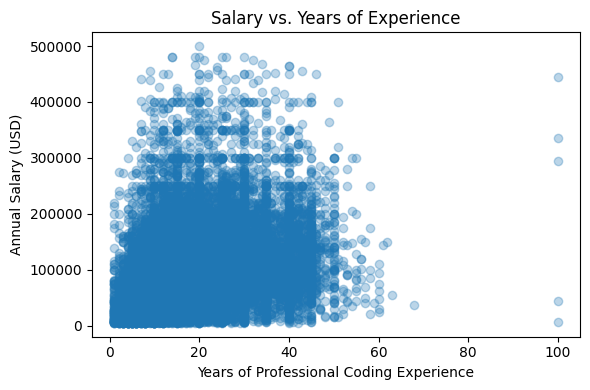

In [11]:
#Explore the effect of Coding experience on the Salary

plt.figure(figsize=(6, 4))
plt.scatter(df["YearsCode"], df["salary"], alpha=0.3)
plt.xlabel("Years of Professional Coding Experience")
plt.ylabel("Annual Salary (USD)")
plt.title("Salary vs. Years of Experience")

plt.tight_layout()
plt.savefig("../reports/figures/salary_vs_experience.png", dpi=150)
plt.show()

#### Observations
- Salary increase with years of coding experience.
- However, data is in wide range of variance, suggesting other factors also matter.

#### Question 2: How does the role affect the salary of developers?
- To answer this question, a boxplot graph is created to observe the salary distributions for each role.

C:\Users\witch\AppData\Local\Temp\ipykernel_18080\3128444443.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  role_subset["PrimaryRole"] = pd.Categorical(


<Figure size 1000x200 with 0 Axes>

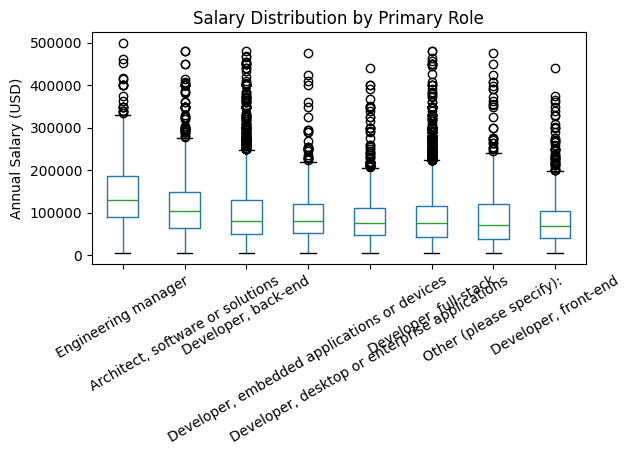

In [12]:
# Salary distribution by roles (for the 8 most reported role type)

top_roles = (
    df["PrimaryRole"]
    .value_counts()
    .head(8)
    .index
)

role_subset = df[df["PrimaryRole"].isin(top_roles)]

# Calculate median salary for each role and sort in descending order
median_salaries = role_subset.groupby("PrimaryRole")["salary"].median().sort_values(ascending=False)

# Get roles in order of decreasing median salary
roles_ordered_by_median = median_salaries.index.tolist()

# Update the PrimaryRole column to be categorical with the desired order
role_subset["PrimaryRole"] = pd.Categorical(
    role_subset["PrimaryRole"], 
    categories=roles_ordered_by_median, 
    ordered=True
)

plt.figure(figsize=(10, 2))
role_subset.boxplot(
    column="salary",
    by="PrimaryRole",
    rot=30,
    grid=False
)

plt.title("Salary Distribution by Primary Role")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("")

plt.tight_layout()
plt.savefig("../reports/figures/salary_by_role.png", dpi=150)
plt.show()

#### Observations
- Engineering manager has highest median salary than other roles
- The salary range if quite broader due to other reasons, such as country, experience, etc.

#### Question 3: Does developer salary vary with country?
- To answer this question, a boxplot graph is created to compare salaries from different countries.

C:\Users\witch\AppData\Local\Temp\ipykernel_18080\440373372.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_subset["Country"] = pd.Categorical(


<Figure size 600x200 with 0 Axes>

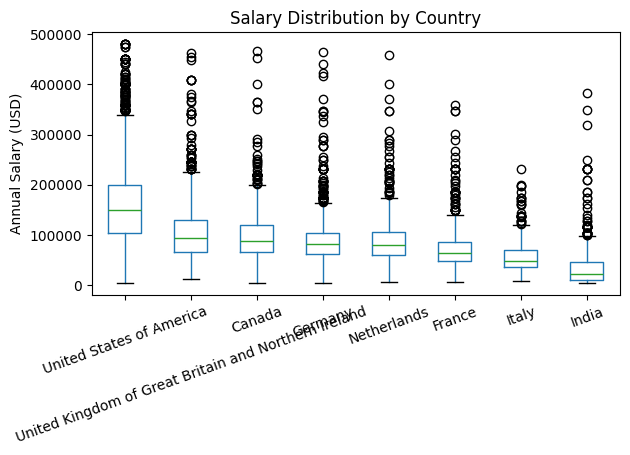

In [13]:
# Salary distribution by country

top_countries = (
    df["Country"]
    .value_counts()
    .head(8)
    .index
)

country_subset = df[df["Country"].isin(top_countries)]

median_salaries = country_subset.groupby("Country")["salary"].median().sort_values(ascending=False)
country_ordered_by_median = median_salaries.index.tolist()
country_subset["Country"] = pd.Categorical(
    country_subset["Country"], 
    categories=country_ordered_by_median, 
    ordered=True
)

plt.figure(figsize=(6, 2))
country_subset.boxplot(
    column="salary",
    by="Country",
    rot=20,
    grid=False
)

plt.title("Salary Distribution by Country")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("")

plt.tight_layout()
plt.savefig("../reports/figures/salary_by_country.png", dpi=150)
plt.show()

#### Observations
- Developers from United States have highest median salary compared to other countries. 

#### Questions 4: Would education level change the salary of developers?
- To answer this question, a boxplot graph is created to compare salaries of develops with different educations.

C:\Users\witch\AppData\Local\Temp\ipykernel_18080\398375730.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edu_subset["EdLevel"] = pd.Categorical(
C:\Users\witch\AppData\Local\Temp\ipykernel_18080\398375730.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 600x200 with 0 Axes>

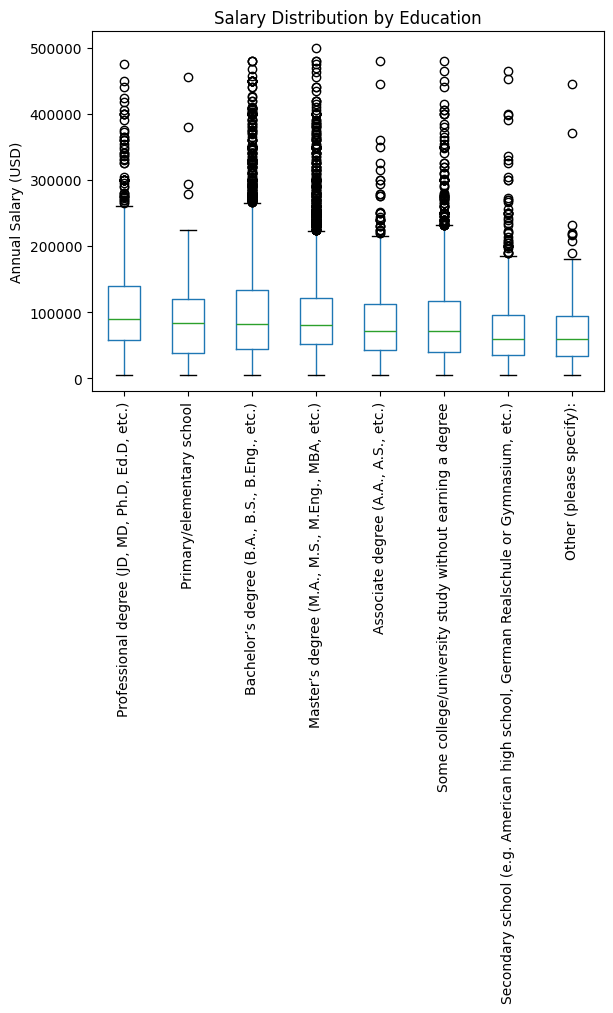

In [14]:
#Salary distribution by education

top_edu = (
    df["EdLevel"]
    .value_counts()
    .head(8)
    .index
)

edu_subset = df[df["EdLevel"].isin(top_edu)]

median_salaries = edu_subset.groupby("EdLevel")["salary"].median().sort_values(ascending=False)
edu_ordered_by_median = median_salaries.index.tolist()
edu_subset["EdLevel"] = pd.Categorical(
    edu_subset["EdLevel"], 
    categories=edu_ordered_by_median, 
    ordered=True
)

plt.figure(figsize=(6, 2))
edu_subset.boxplot(
    column="salary",
    by="EdLevel",
    rot=90,
    grid=False
)

plt.title("Salary Distribution by Education")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("")

plt.tight_layout()
plt.savefig("../reports/figures/salary_by_education.png", dpi=150)
plt.show()

#### Observations
- The education level has marginal influence on the median salary of developers.

#### Question 5: Which language has highest salary?
- To answer this question, a boxplot graph is created to compare salaries across different programming languages.

C:\Users\witch\AppData\Local\Temp\ipykernel_18080\841397439.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lang_subset["PrimaryLanguage"] = pd.Categorical(


<Figure size 600x200 with 0 Axes>

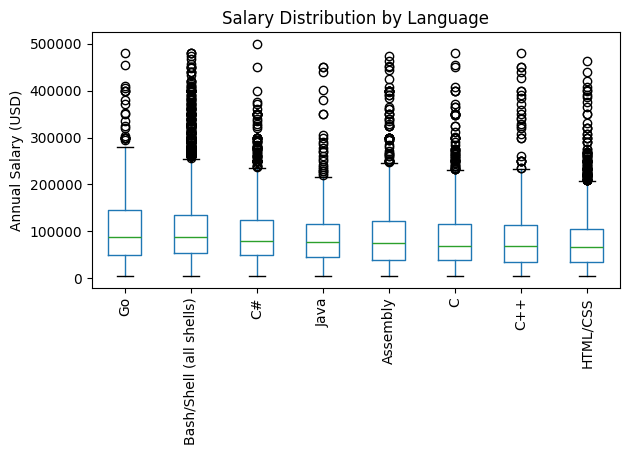

In [15]:
#Salary distribution by language

top_lang = (
    df["PrimaryLanguage"]
    .value_counts()
    .head(8)
    .index
)

lang_subset = df[df["PrimaryLanguage"].isin(top_lang)]

median_salaries = lang_subset.groupby("PrimaryLanguage")["salary"].median().sort_values(ascending=False)
lang_ordered_by_median = median_salaries.index.tolist()
lang_subset["PrimaryLanguage"] = pd.Categorical(
    lang_subset["PrimaryLanguage"], 
    categories=lang_ordered_by_median, 
    ordered=True
)

plt.figure(figsize=(6, 2))
lang_subset.boxplot(
    column="salary",
    by="PrimaryLanguage",
    rot=90,
    grid=False
)

plt.title("Salary Distribution by Language")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("")

plt.tight_layout()
plt.savefig("../reports/figures/salary_by_language.png", dpi=150)
plt.show()

#### Observations
- The language has marginal influence on the median salary of developers.

#### Question 6: Can we train a Random Forest Model to predict salary using selected features?

#### Step 1. Prepare the training and testing datasets
- One-hot encoding for categorical features
- 80/20 train-test split

In [16]:
X = df.drop(columns="salary")
y = df["salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
categorical_features = [
    "Country",
    "PrimaryRole",
    "PrimaryLanguage",
    "EdLevel"
]

numeric_features = ["YearsCode"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

#### Step 2. Select the model and set up the hyperparameters

In [18]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

#### Step 3. Train the model and save it

In [19]:
pipeline = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", model)
    ]
)

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Country', 'PrimaryRole',
                                                   'PrimaryLanguage',
                                                   'EdLevel']),
                                                 ('num', 'passthrough',
                                                  ['YearsCode'])])),
                ('model',
                 RandomForestRegressor(max_depth=12, n_jobs=-1,
                                       random_state=42))])

In [21]:
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "salary_rf_pipeline.joblib")
joblib.dump(pipeline, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to ../models\salary_rf_pipeline.joblib


#### Step 4. Evaluate the model

In [22]:
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: ${mae:,.0f}")
print(f"R²: {r2:.2f}")

MAE: $34,984
R²: 0.44


Model performance

- **Mean Absolute Error (MAE):** ~$34,984
- **R² Score:** ~0.44

Interpretation:
- Predictions are often within ~$35k of reported salary
- Roughly half of salary variance is explained by the model

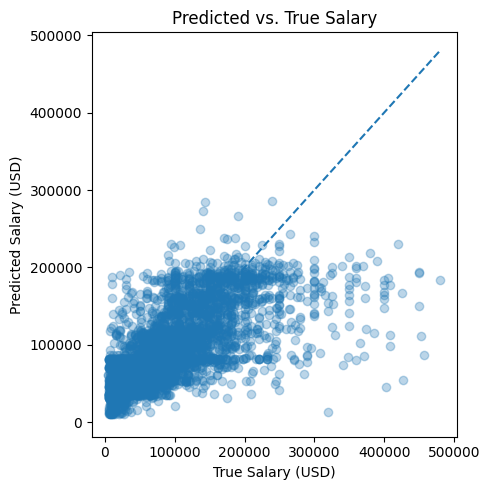

In [23]:
#Prediction vs true salary

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)

plt.xlabel("True Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Predicted vs. True Salary")

plt.tight_layout()
plt.savefig("../reports/figures/predicted_vs_true.png", dpi=150)
plt.show()

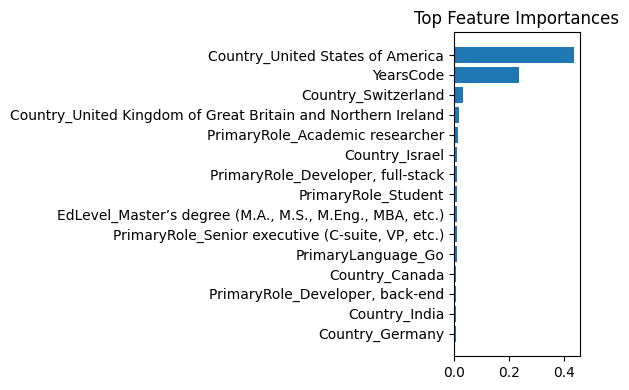

In [24]:
ohe = pipeline.named_steps["prep"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out()

feature_names = list(cat_features) + ["YearsCode"]

importances = pipeline.named_steps["model"].feature_importances_

fi = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(15)
)

plt.figure(figsize=(6, 4))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances")

plt.tight_layout()
plt.savefig("../reports/figures/feature_importance.png", dpi=150)
plt.show()

### Model Interpretation

This model is **not meant to be a production salary predictor**.

Key takeaways:
- Country of United States is the strongest factor
- Years of professional experience is the second strongest factor
- Other factors have marginal influence

Limitations:
- The data is self-reported and may not be accurate
- Model prediction power is limited (R²=0.44)
- Many factors are ignored to simplify the model for demo purpose